# Supervised Learning Project: Colorectal Histology

Automatic recognition of different tissue types in histological images is an essential part of the digital pathology toolbox. Texture analysis is commonly used to solve this problem, mainly in the context of estimating the tumor/stroma ratio on histological samples. However, although histological images typically contain more than two tissue types, only a few studies have addressed the multi-class problem. For colorectal cancer for example, one of the most common tumor types, there are actually no published results on multi-class texture separation. 

For this project, we will work on a dataset of 5,000 human colorectal cancer histological images including eight different tissue types using supervised machine learning model such some basics models or CNN to classify colon tissue types.


# I. Import of libraries

First, we import the libraries necessary for the proper functioning of the project. 

In [61]:
#!pip3 install torch
#!pip3 install torchvision
import os
import random
import itertools
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from sklearn.utils import shuffle
from glob import glob
import seaborn as sns

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report, multilabel_confusion_matrix, accuracy_score
from scipy import stats

import torch
import torch.nn as nn
import torch.utils.data as D
import torch.nn.functional as F

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical

from torchvision import transforms, models

from tqdm import tqdm

from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

torch.cuda.empty_cache()

# II. Explore dataset

The dataset we have is a collection of textures in colorectal cancer histology. It is considered as a MNIST by biologists and can be easily found on Zenodo (https://zenodo.org/record/53169#.XGZemKwzbmGK). 

It contains two folders. One containing 5000 images (Kather_texture_2016_image_tiles_5000) with a resolution of 150X150 pixels where each image belongs exactly to one of the eight tissue categories and the other (Kather_texture_2016_larger_images_10) containing 10 larger histological images of 5000 x 5000 px each. The latter consists of images containing more than one tissue type.

All images are RGB, 0.495 μm per pixel, scanned with an Aperio ScanScope (Aperio/Leica biosystems), 20x magnification. Histological samples are fully anonymized images of paraffin-embedded formalin-fixed human colorectal adenocarcinomas (primary tumors) from pathology archives (Institute of Pathology, University Medical Center Mannheim, University of Heidelberg, Mannheim, Germany).

### 1. Load functions and data

In [75]:
## OpenCV loads color images in BGR mode. For visualization by matplotlib, images need to be converted to RGB mode
def readImage_rgb(img_path):
    '''OpenCV loads color images in BGR mode and converts to RGB mode for visualization;
       output: (H x W x n_channel)'''
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    return img_rgb

# Visualize images files
def plotImage_cat(img_files, img_labels):
    fig = plt.figure(figsize=(25,20))
    for i in np.arange(len(img_labels)):
        img_paths = img_files[i]
        img_label = img_labels[i]
        np.random.shuffle(img_paths)
        img_paths = img_paths[:8]
        for j, img_path in enumerate(img_paths):
            fig.add_subplot(8,8,i*8+j+1, xticks = [], yticks = [])
            plt.imshow(readImage_rgb(img_path))
            if j == 0:
                plt.ylabel(img_label.split('_')[1], rotation = 0, labelpad=100, fontsize=30, fontweight = 'bold')
    plt.tight_layout() 

def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

We will consider the folder containing the 5000 images of 150x150 pixels resolution. To feed the images into the ResNet CNN model, we need to resize them to 224 x 224 pixels

In [76]:
# Path to access data. Define the access path to the folder containing the 5000 images and the 10 larges images
DATA_DIR = "C:/Users/sieza/OneDrive/Bureau/Supervised learning Project/"
SMALL_IMG_DATA_DIR = os.path.join(DATA_DIR, 'kather_texture_2016_image_tiles_5000/Kather_texture_2016_image_tiles_5000')
LARGE_IMG_DATA_DIR = os.path.join(DATA_DIR, 'kather_texture_2016_larger_images_10/Kather_texture_2016_larger_images_10')

# Set up some parameters for the data
IMAGE_SIZE = 224
SEED = 2000
BATCH_SIZE = 64
#NUM_EPOCHS = 15

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Define the device to use
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 2. Data exploration

In [77]:
# Get labels of all classes in this dataset
img_labels = [i for i in os.listdir(SMALL_IMG_DATA_DIR) if not i.startswith('.')]
print('There are {} classes in this dataset:\n{}'.format(len(img_labels), img_labels))

There are 8 classes in this dataset:
['01_TUMOR', '02_STROMA', '03_COMPLEX', '04_LYMPHO', '05_DEBRIS', '06_MUCOSA', '07_ADIPOSE', '08_EMPTY']


In [78]:
# Get the number of images in the dataset and per category
tumor_files = glob(os.path.join(SMALL_IMG_DATA_DIR, img_labels[0], '*.tif'))
stroma_files = glob(os.path.join(SMALL_IMG_DATA_DIR, img_labels[1], '*.tif'))
complex_files = glob(os.path.join(SMALL_IMG_DATA_DIR, img_labels[2], '*.tif'))
lympho_files = glob(os.path.join(SMALL_IMG_DATA_DIR, img_labels[3], '*.tif'))
debris_files = glob(os.path.join(SMALL_IMG_DATA_DIR, img_labels[4], '*.tif'))
mucosa_files = glob(os.path.join(SMALL_IMG_DATA_DIR, img_labels[5], '*.tif'))
adipose_files = glob(os.path.join(SMALL_IMG_DATA_DIR, img_labels[6], '*.tif'))
empty_files = glob(os.path.join(SMALL_IMG_DATA_DIR, img_labels[7], '*.tif'))
img_files = [tumor_files, stroma_files, complex_files, lympho_files, debris_files, mucosa_files, adipose_files, empty_files]
total_files = [img for folder in img_files for img in folder]

In [79]:
print('The total number of images in this dataset is: {}'.format(len(total_files)))
print ('-'*50)
for i in np.arange(8):
    print('The number of images for {} category is: {}'.format(img_labels[i].split('_')[1], len(img_files[i])))

The total number of images in this dataset is: 5000
--------------------------------------------------
The number of images for TUMOR category is: 625
The number of images for STROMA category is: 625
The number of images for COMPLEX category is: 625
The number of images for LYMPHO category is: 625
The number of images for DEBRIS category is: 625
The number of images for MUCOSA category is: 625
The number of images for ADIPOSE category is: 625
The number of images for EMPTY category is: 625


In [80]:
img = readImage_rgb(img_files[0][0])
print(img.shape)

(150, 150, 3)


In summary, there are exactly, in the first folder 5000 images evenly distributed in 8 classes with 625 images per class. It's a multiclass classification. Let's have a look of the class:

- TUMOR: Tumour epithelium
- STROMA: Simple stroma (homogeneous composition, includes tumour stroma, extra-tumoural stroma and smooth muscle)
- COMPLEX: Complex stroma (containing single tumour cells and/or few immune cells)
- LYMPHO: Immune cells (including immune-cell conglomerates and sub-mucosal lymphoid follicles)
- DEBRIS: Debris (including necrosis, hemorrhage and mucus)
- MUCOSA: Normal mucosal glands
- ADIPOSE: Adipose tissue
- EMPTY: Background (no tissue)

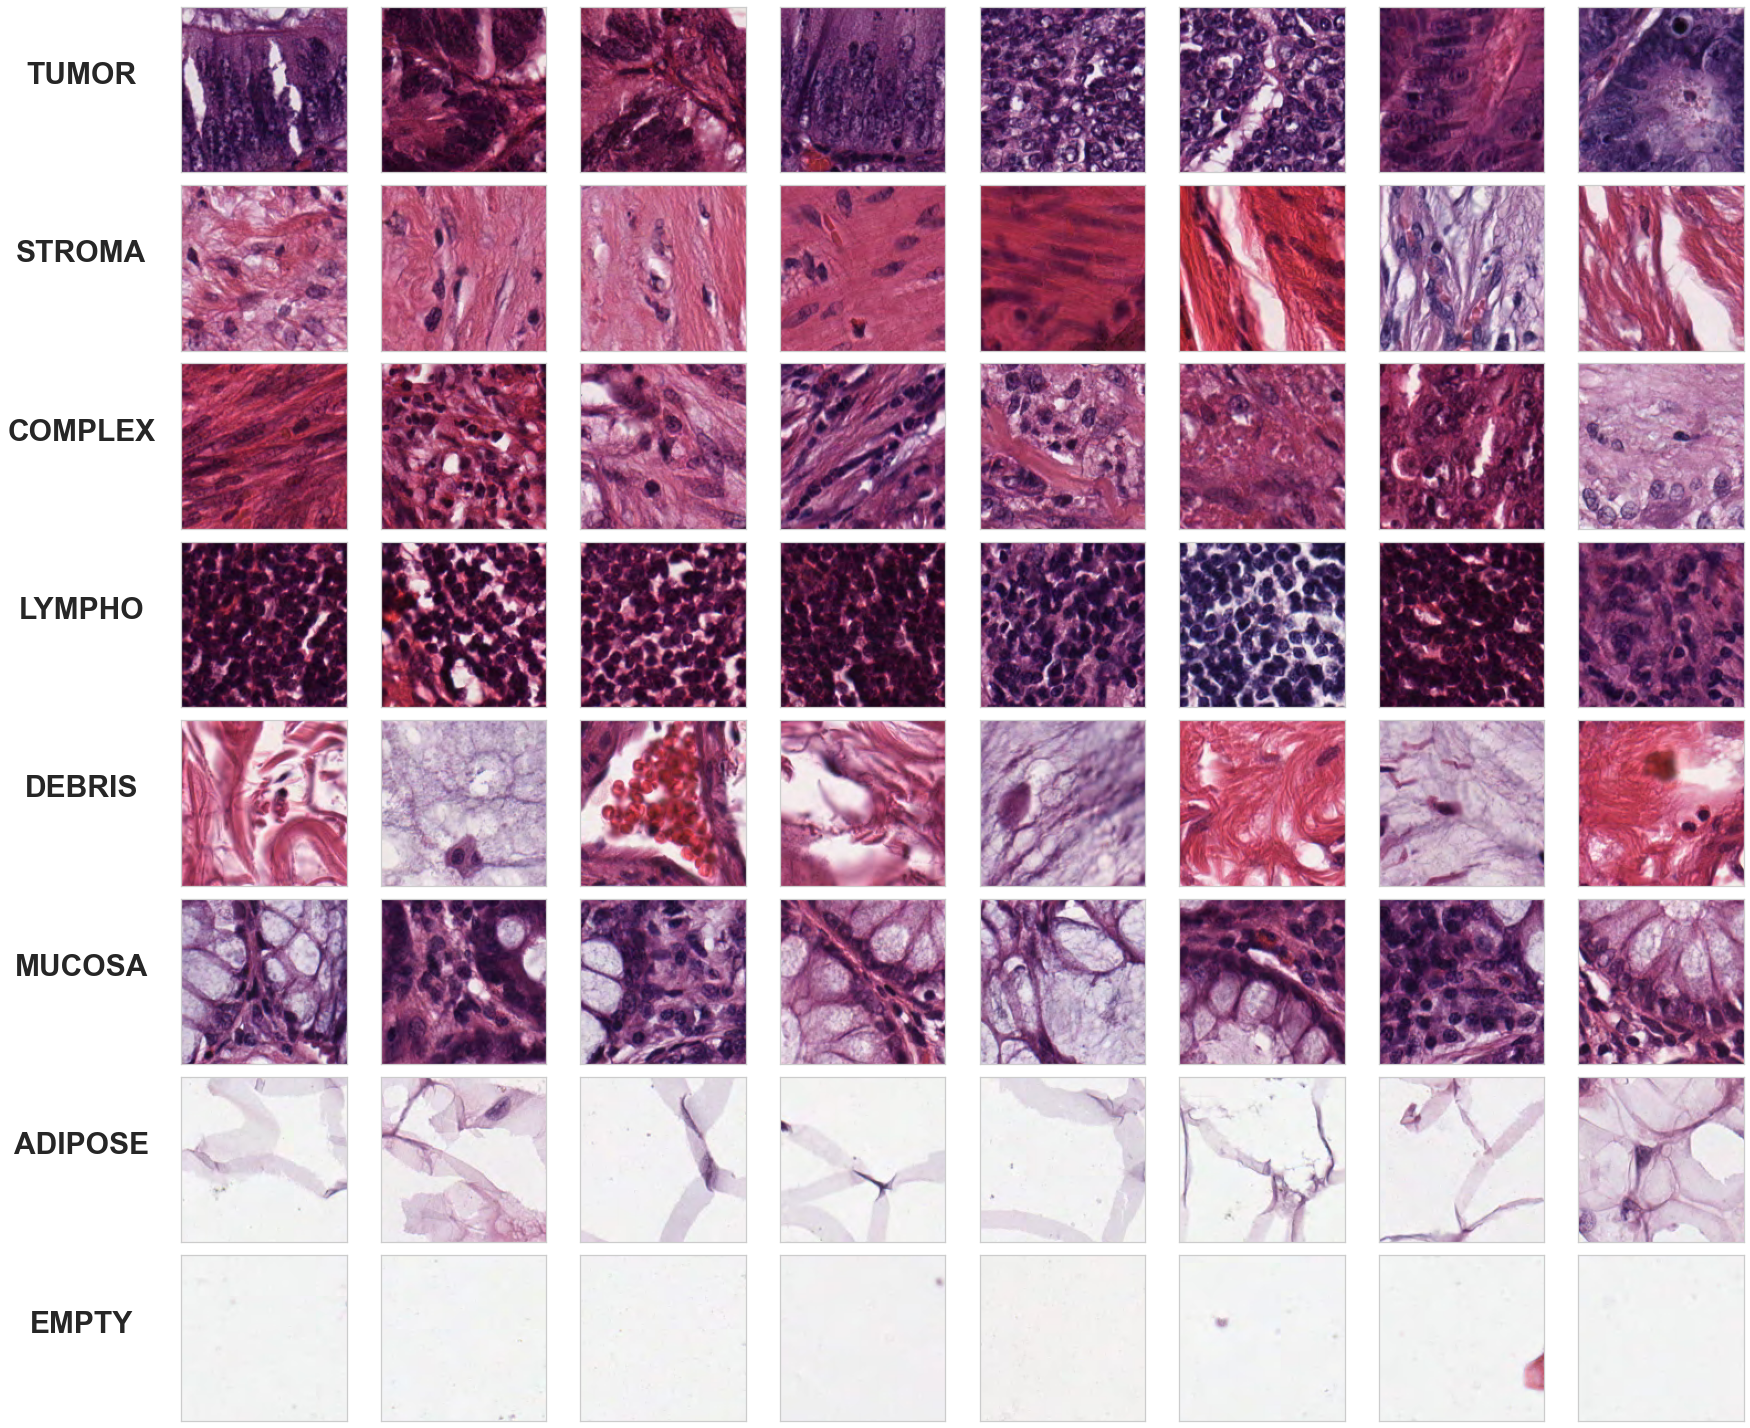

In [81]:
# Display several images from each class
plotImage_cat(img_files, img_labels)

### 3. Image pixel statistics

#### 3.1 Import of the intensity distribution of individual pixels for each image class

In addition to the images, the dataset also provides individual pixel values for each image at different resolutions. In order to get a better understanding of the pixel pattern for each class, we will use the pixel values calculated at the resolution of 64x64 pixels, i.e. in gray scale.

In [82]:
# Read the csv file
pixels = pd.read_csv('C:/Users/sieza/OneDrive/Bureau/Supervised learning Project/hmnist_64_64_L.csv')

In [83]:
pixels.shape

(5000, 4097)

In [84]:
pixels.head()

pixel0000  pixel0001  pixel0002  pixel0003  pixel0004  pixel0005  \
0        134         99        119        130        142        169   
1         55         64         74         63         74         75   
2        114        116        136        152        132        100   
3         86         82         88         85        103         93   
4        168        143        140        139        129        123   

   pixel0006  pixel0007  pixel0008  pixel0009  ...  pixel4087  pixel4088  \
0        152        139        117         87  ...        112         89   
1         71         73         70         77  ...         79         85   
2        151        150        127        205  ...        128        157   
3         98        109        104        115  ...         79         80   
4        123        141        137        101  ...        231        199   

   pixel4089  pixel4090  pixel4091  pixel4092  pixel4093  pixel4094  \
0         73        100        120        120        126        140   
1         86         77         68         66         65         68   
2        159        205        182        143        129         89   
3        109        128         89         85         80         63   
4        183        195        179        134        142        158   

   pixel4095  label  
0        195      2  
1         69      2  
2        122      2  
3         48      2  
4        149      2  

[5 rows x 4097 columns]

#### 3.2 Compare the intensity distribution of individual pixels for each image class

In [85]:
# Make labeling system more consistent, convert label from [1-8] to [0-7]
pixels['label'] = pixels.label-1
np.unique(pixels.label)

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64)

Text(0.5, 0.98, '64x64px grayscale images for colorectal histology')

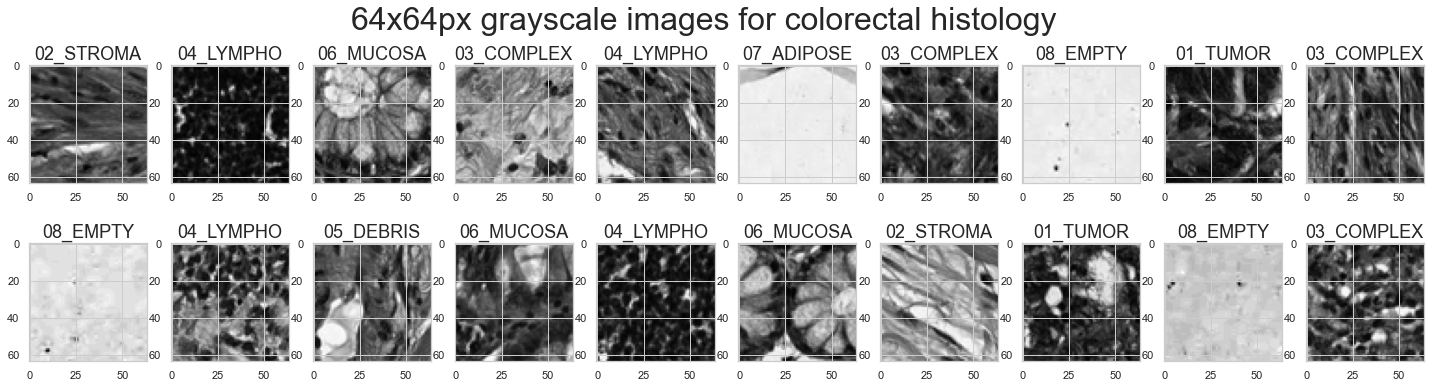

In [86]:
# Visualize grayscale images in 64X64 pixels
classes = img_labels
fig = plt.figure(figsize=(25,6))
label_to_class_dict = {i:l for i,l in enumerate(classes)}
pixel_array = np.random.choice(len(pixels), 20)
for i, idx in enumerate(pixel_array):
    fig.add_subplot(2,10,i+1)
    img = pixels.iloc[idx,:-1]
    label = pixels.label[idx]
    plt.imshow(np.array(img).reshape(64,64), cmap = 'gray')
    plt.title(label_to_class_dict[label], fontsize=18)
fig.suptitle('64x64px grayscale images for colorectal histology', fontsize = 32)

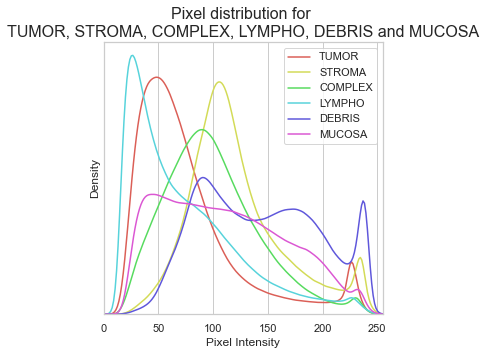

In [87]:
# Plot the the distrisbution of each class for comparison
palette = sns.color_palette('hls', 6)
fig, ax = plt.subplots(1,1, figsize=(5,5))
for i in np.arange(6):
    label = img_labels[i].split('_')[1]
    sns.distplot(pixels[pixels.label == i].drop("label", axis=1).values.flatten(), hist = False, bins = 50, label = label, color=palette[i])
ax.set_title('Pixel distribution for \nTUMOR, STROMA, COMPLEX, LYMPHO, DEBRIS and MUCOSA', fontsize=16)
ax.set_xlabel('Pixel Intensity', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_xlim(0,255)
ax.set_yticks([])
ax.legend()

Through this comparison, we can draw the following conclusions: 

- Both the EMPTY class and the ADIPOSE class show a sharp and high intensity peak, which is consistent with the previous results.

- Like the DEBRIS class, the MUCOSA class also shows a very broad intensity distribution, which could be due to the high cellular heterogeneity of the mucosa. The mucosa has different cell types and secretes mucus which can also be stained and adds even more heterogeneity.

- The LYMPHO contains lymphocytes that have a large nucleus with little cytoplasm. Since the nucleus will be strongly stained with a "dark"/"blue" appearance and the tumor-infiltrating lymphocytes often have a high local density, the LYMPHO class has a much lower pixel intensity than the other classes.

- The TUMOR class has a lower pixel intensity than the STROMA class. This may be due to the large and irregular nucleus possessed by cancer cells. The COMPLEX has a peak in intensity between the TUMOR and STROMA classes.

# III. Building models

### 1. Base models

For this project, we first build the K-Nearest-Neighbors, Logistic Regression and Random Forest. And to do this, we will use the dataframe containing the intensity of individual pixels for each image class (hmnist_64_64_L.csv). 

The models set up obviously make no sense because the characteristics of an image do not depend on individual pixels but rather on patterns. But, we can use them as a reference base for the other methods we will set up. 

In [88]:
# Visualize the dataframe 
pixels.head()

pixel0000  pixel0001  pixel0002  pixel0003  pixel0004  pixel0005  \
0        134         99        119        130        142        169   
1         55         64         74         63         74         75   
2        114        116        136        152        132        100   
3         86         82         88         85        103         93   
4        168        143        140        139        129        123   

   pixel0006  pixel0007  pixel0008  pixel0009  ...  pixel4087  pixel4088  \
0        152        139        117         87  ...        112         89   
1         71         73         70         77  ...         79         85   
2        151        150        127        205  ...        128        157   
3         98        109        104        115  ...         79         80   
4        123        141        137        101  ...        231        199   

   pixel4089  pixel4090  pixel4091  pixel4092  pixel4093  pixel4094  \
0         73        100        120        120        126        140   
1         86         77         68         66         65         68   
2        159        205        182        143        129         89   
3        109        128         89         85         80         63   
4        183        195        179        134        142        158   

   pixel4095  label  
0        195      1  
1         69      1  
2        122      1  
3         48      1  
4        149      1  

[5 rows x 4097 columns]

### 1.1 Train the data

The dataframe will be divided into training, validation and test data. Since the data is also divided into different classes, we might as well make our training, validation and test data have the same structure.

In [89]:
images = pixels

temp, images_val = train_test_split(images, test_size = 0.2, stratify = images.label.values, random_state = 23)
images_train, images_test = train_test_split(temp, test_size = 0.2, stratify = temp.label.values, random_state = 24)

features = images.columns.tolist()
features.remove('label')

# Features, label split
images_train_feature = images_train[features]
images_train_label = np.array(images_train['label'])
images_test_feature=images_test[features]
images_test_label=np.array(images_test['label'])

### 1.2 Evaluate Models

In [90]:
# Set up a function to evaluate the models 
def evaluate_models(in_model_maker,label):
    fig, ax = plt.subplots(1, 1, figsize = (10, 10))
    
    c_df = images.copy()
    c_label = c_df.pop('label')
    c_model = in_model_maker()
    
    c_model.fit(images_train_feature,images_train_label)
    c_pred = c_model.predict(images_test_feature)
    sns.heatmap(confusion_matrix(images_test_label, c_pred), 
                    annot=True, cbar=False, fmt='d')
    print(accuracy_score(images_test_label,c_pred))
    ax.set_title('Accuracy: {}, {}'.format(accuracy_score(images_test_label,c_pred),label),fontsize = 20)

- K-Nearest-Neighbors Classifier

0.36875


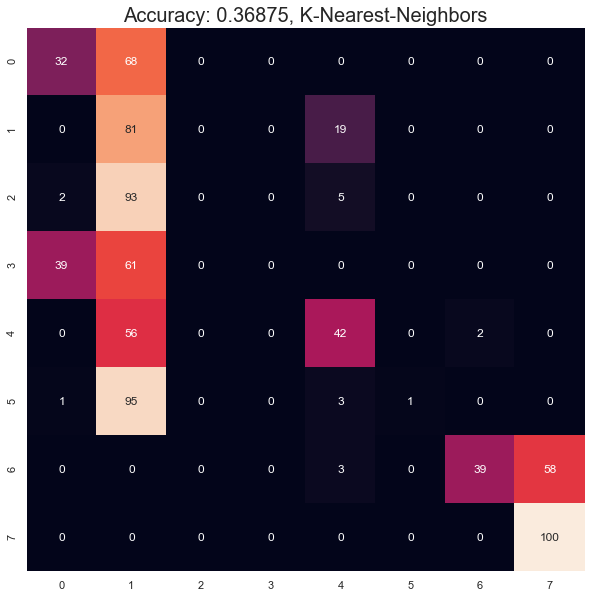

In [91]:
from sklearn.neighbors import KNeighborsClassifier
evaluate_models(lambda : KNeighborsClassifier(n_jobs=1), 'K-Nearest-Neighbors')

- Logistic Regression

0.22875


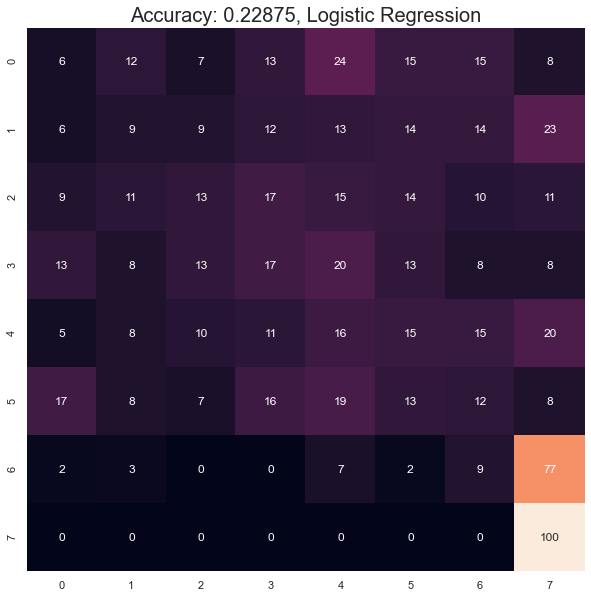

In [92]:
from sklearn.linear_model import LogisticRegression
evaluate_models(lambda : LogisticRegression(n_jobs=1, solver='lbfgs'), 'Logistic Regression')

- Random Forest Classifier

0.69125


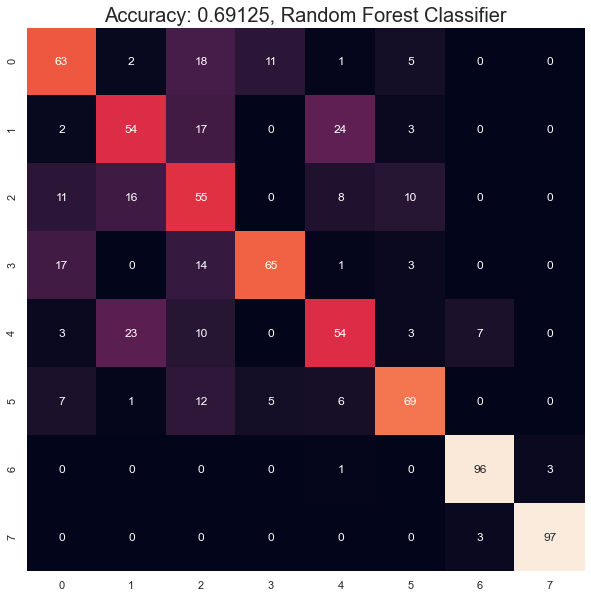

In [93]:
from sklearn.ensemble import RandomForestClassifier
evaluate_models(lambda : RandomForestClassifier(n_jobs=1), 'Random Forest Classifier')

### 1.3 Images statistics

Having looked at the images, let's now look at some basic statistics about these images. 

KeyError: 8

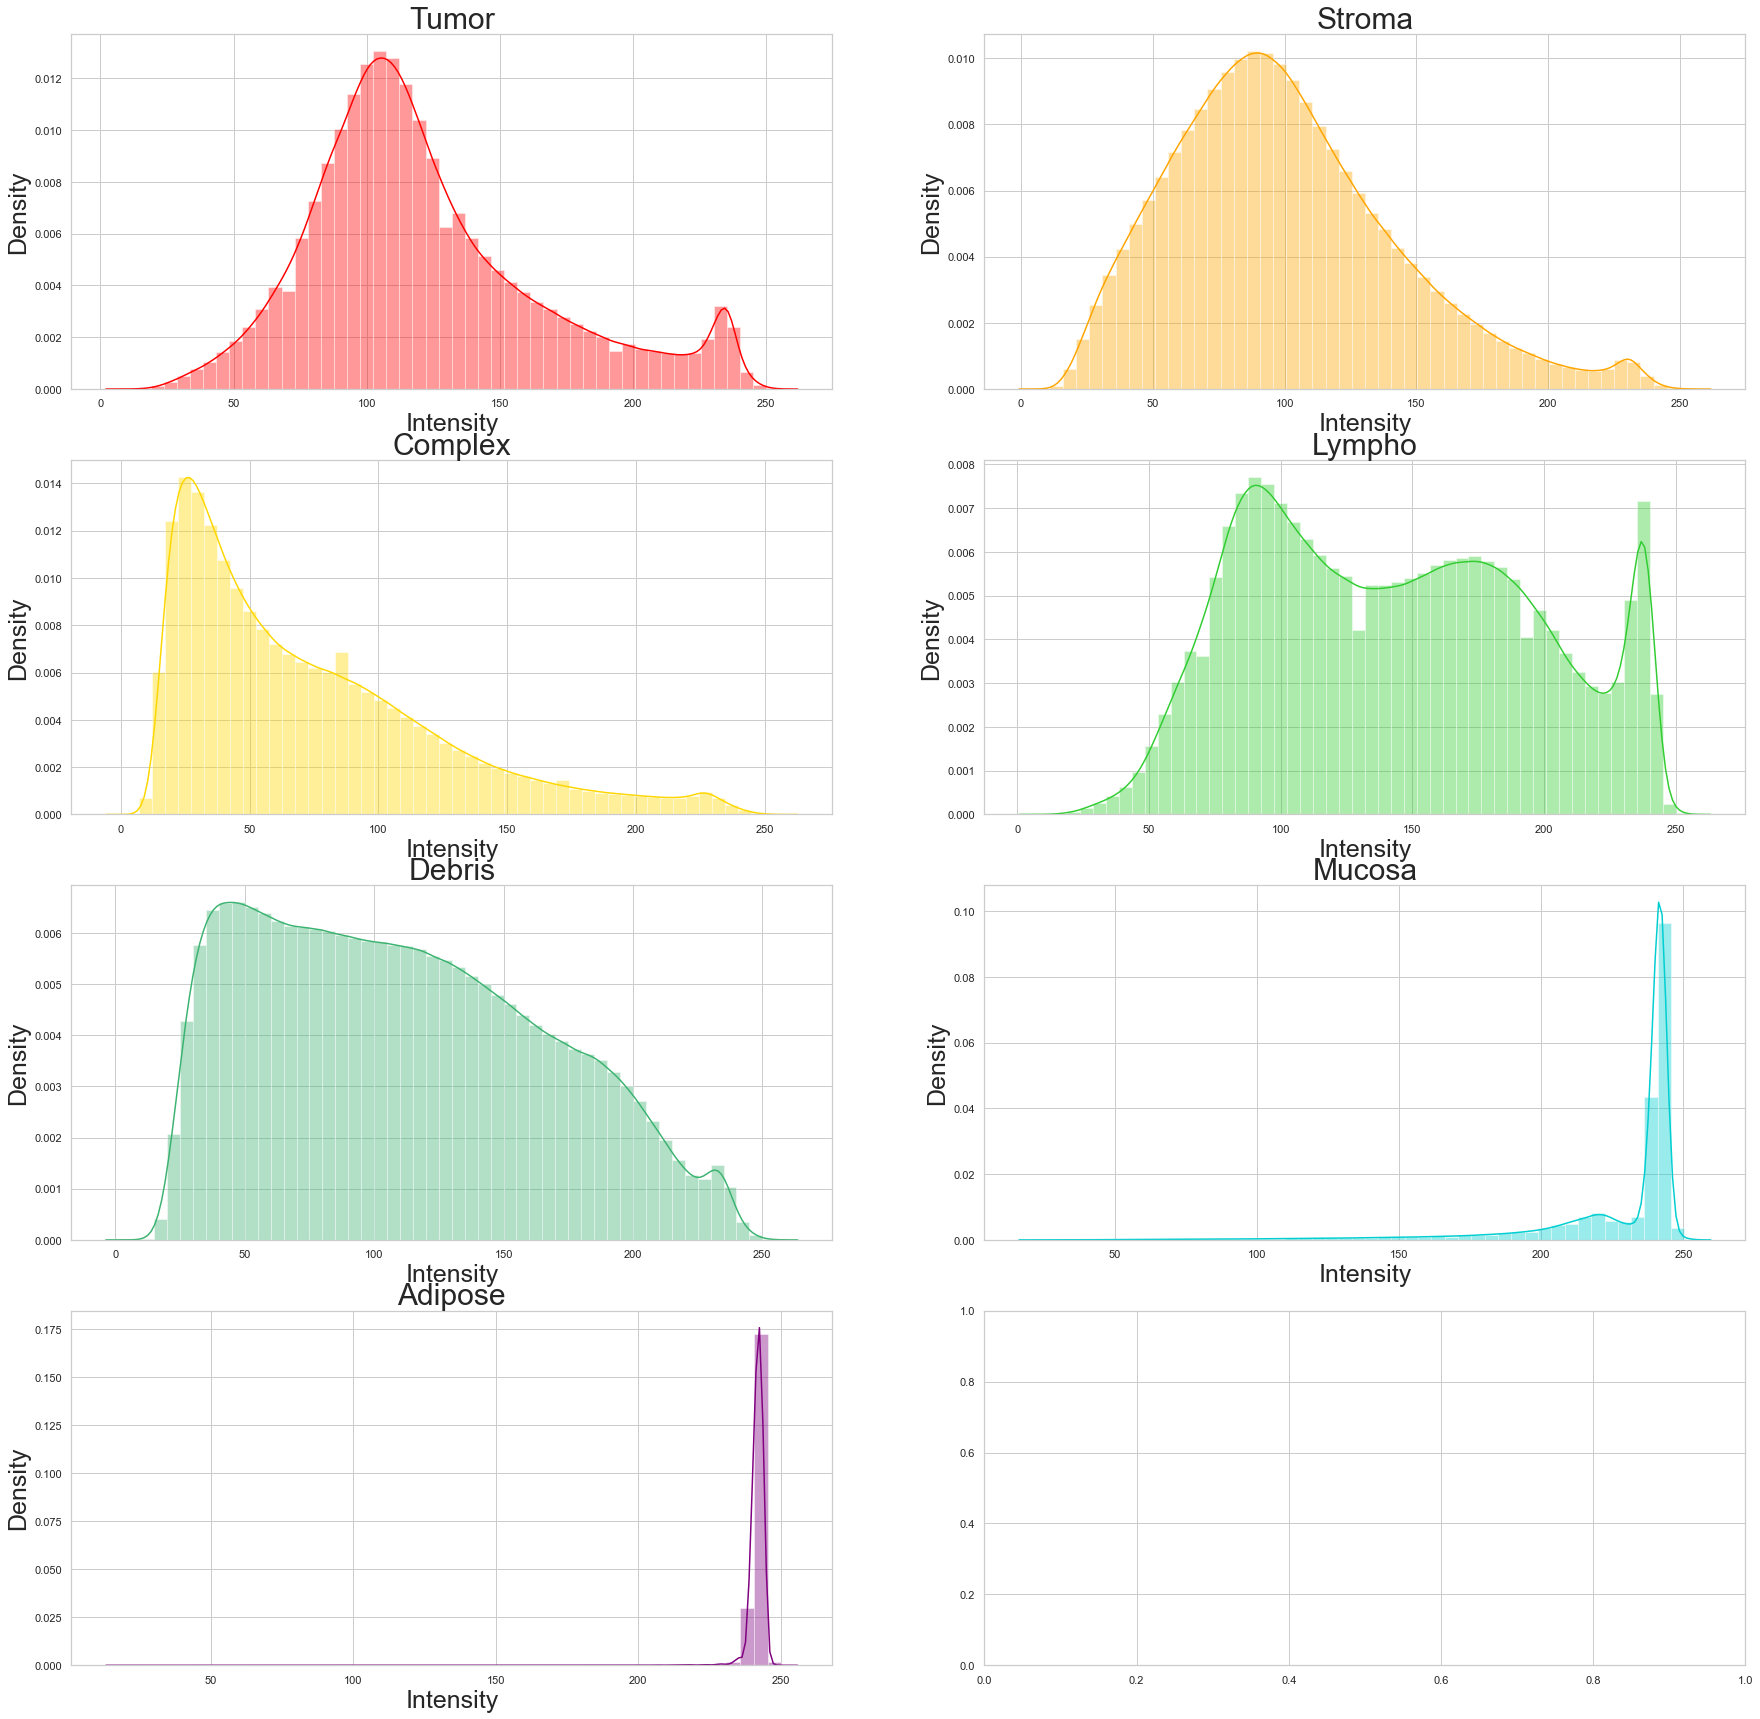

In [103]:
class_names = {1: "Tumor", 2: "Stroma", 3: "Complex", 4: "Lympho",
               5: "Debris", 6: "Mucosa", 7: "Adipose", 8: "Empty"}
class_colors = {1: "Red", 2: "Orange", 3: "Gold", 4: "Limegreen",
                5: "Mediumseagreen", 6: "Darkturquoise", 7: "Steelblue", 7: "Purple"}
sns.set_style("whitegrid")
fig, ax = plt.subplots(4,2, figsize=(30,30))
for n in range(4):
    for m in range(2):
        class_idx = n*2+(m+1)
        sns.distplot(images[images.label == class_idx].drop("label", axis=1).values.flatten(),
                     ax=ax[n,m],
                     color=class_colors[class_idx])
        ax[n,m].set_title(class_names[class_idx],fontsize = 30)
        ax[n,m].set_xlabel("Intensity", fontsize = 25)
        ax[n,m].set_ylabel("Density", fontsize = 25)

We see on this graph that the intensity density of ADIPOSE fabrics is strongly concentrated on a high value. This fact allows to differentiate this class together with the EMPTY class from the others! The other classes have a bimodal or trimodal curve. 

We examine the intensity mode of each individual image and compare it to the mode of the total distribution. 

In [111]:
image_statistics = pd.DataFrame(index=images.index)
image_statistics["{}".format('Mode')] = images.apply(lambda l: stats.mode(l)[0][0], axis=1)
for q in range(1, 10):
    col_name = "Q" + str(q*10)
    image_statistics[col_name] = images.apply(lambda l: np.quantile(l, (q*10)/100), axis=1)

image_statistics["label"] = images.label.values
image_statistics.head()

Mode   Q10    Q20    Q30    Q40    Q50    Q60    Q70    Q80    Q90  label
0   122  82.0  100.0  112.0  122.0  130.0  140.0  152.0  167.0  189.0      1
1    71  44.0   53.0   60.0   67.0   73.0   79.0   85.0   95.0  120.4      1
2   122  75.0   95.0  108.0  117.0  127.0  137.6  150.0  166.0  193.0      1
3    99  72.0   81.0   87.0   93.0   97.0  102.0  108.0  116.0  132.0      1
4   125  90.0  104.0  114.0  123.0  131.0  141.0  152.0  163.0  181.0      1

KeyError: 8

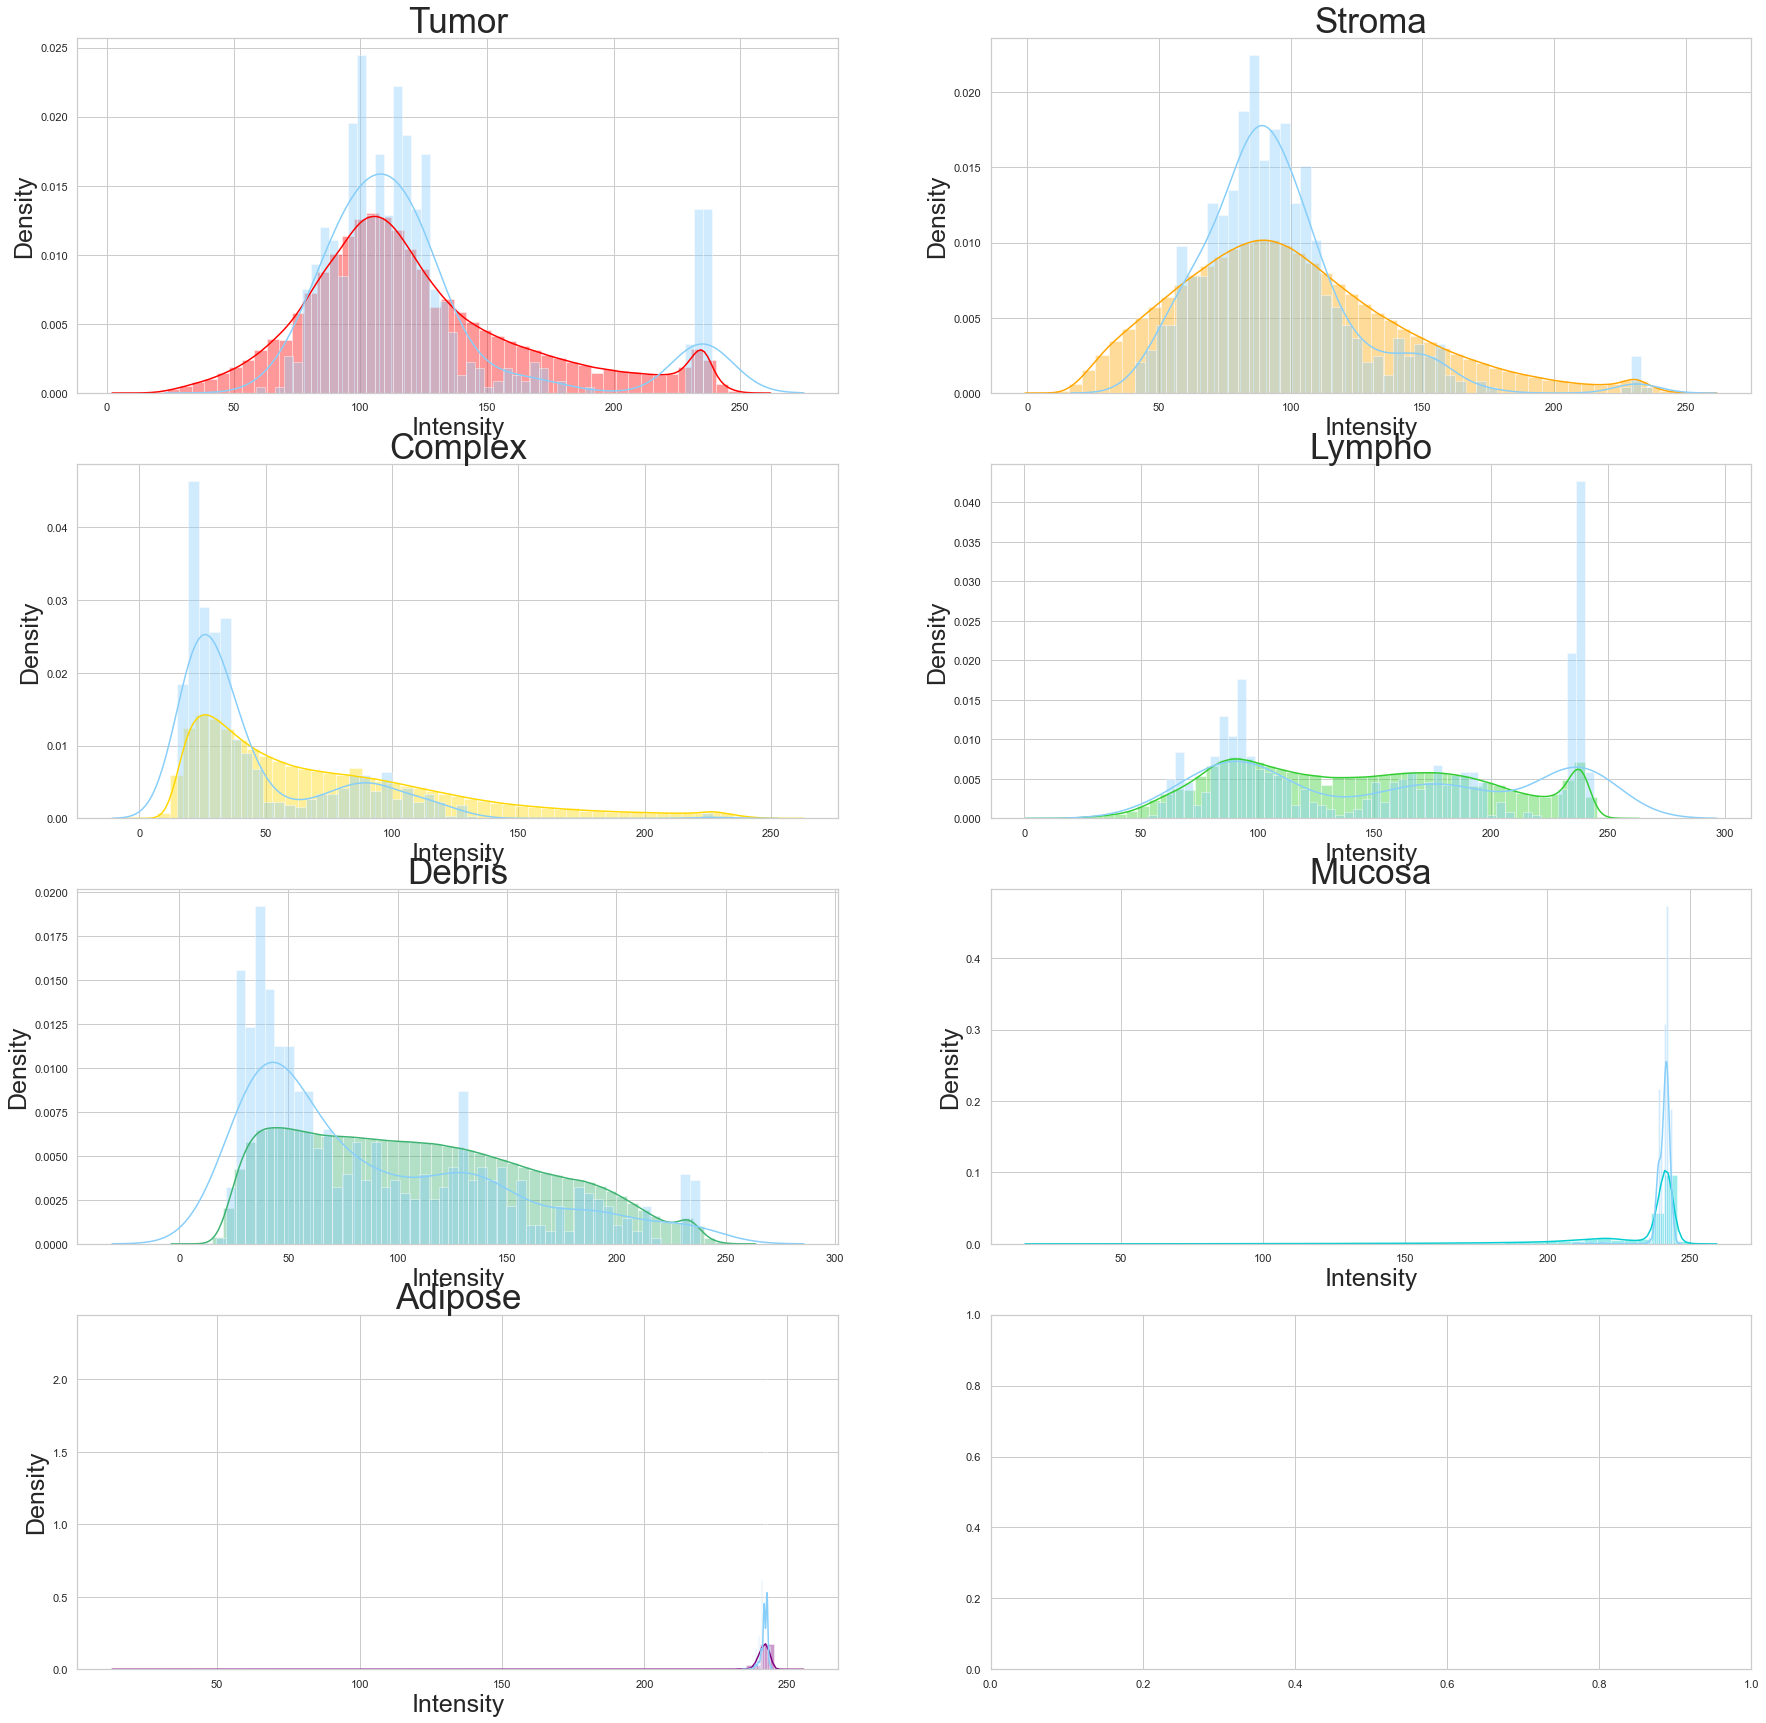

In [112]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(4,2, figsize=(30,30))
for n in range(4):
    for m in range(2):
        class_idx = n*2+(m+1)
        sns.distplot(images[images.label == class_idx].drop("label", axis=1).values.flatten(),
                     ax=ax[n,m],
                     color=class_colors[class_idx], 
                     norm_hist=True,
                     bins=50)
        sns.distplot(image_statistics[image_statistics.label == class_idx]['Mode'].values,
                     ax=ax[n,m],
                     color="lightskyblue",
                     norm_hist=True, 
                     bins=50)
        ax[n,m].set_title(class_names[class_idx], fontsize = 35)
        ax[n,m].set_xlabel("Intensity", fontsize = 25)
        ax[n,m].set_ylabel("Density", fontsize = 25)

Here we can see that the mode density of each individual image stacks with the peaks of the intensity graph of the total distribution. This indicates that there are outliers (different types of images than those with the other mode). Let's take the example of the tumor. The intensity distribution of all images is bimodal. The mode distribution of each image is also bimodal. This indicates that the images with the highest mode intensity have a lot of white space (high intensity) but were still classified as Tumor. The same argument holds for the stroma, debris and partly for the complex.

### 2. Neural Network

In this section, we will now model a neural network on this data to classify tissue types.

We will use Keras to create a convolutional neural network. 

Here is a quick description of what a CNN does:
To build a simple CNN, there are 3 types of layers: Convolution, Pooling, and Fully-connected. The convolution layer applies a filter (kernel) to transform the input image into another type of image. Pooling, on the other hand, reduces the dimensionality of the image. The fully connected layer is the typical layer of a multilayer perceptor. 

In [124]:
images_label = images['label']
images_features = images.drop(['label'],axis=1, inplace = False)

images_features=images_features/255.0

In [125]:
images_features = images_features.values.reshape(-1,64,64,1)
images_label = images_label.values
images_label = to_categorical(images_label)

In [126]:
temp_features, images_val_features, temp_label, images_val_label = train_test_split(images_features, images_label, test_size = 0.2, stratify = images_label, random_state = 4)
images_train_features, images_test_features, images_train_label, images_test_label = train_test_split(temp_features, temp_label, test_size = 0.2, stratify = temp_label, random_state = 4)

In [127]:
print(images_train_features.shape)
print(images_val_features.shape)
print(images_test_features.shape)
print(images_train_label.shape)
print(images_val_label.shape)
print(images_test_label.shape)

(3200, 64, 64, 1)
(1000, 64, 64, 1)
(800, 64, 64, 1)
(3200, 8)
(1000, 8)
(800, 8)


In [128]:
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()

model = Sequential()

model.add(Conv2D(filters = 128, kernel_size = (5,5), padding = 'same', activation = 'relu', input_shape = (64,64,1)))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.35))

model.add(Conv2D(filters = 64, kernel_size = (4,4),padding = 'same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.35))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.35))


model.add(Flatten())

#model.add(Dense(512,activation = "relu"))      
model.add(Dense(256,activation = "relu"))      
model.add(Dense(128,activation = "relu"))
model.add(Dense(64,activation = "relu"))
model.add(Dense(32,activation = "relu"))
model.add(Dense(16,activation = "relu"))

model.add(Dense(8, activation = "softmax"))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 64, 64, 128)       3328      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 32, 32, 128)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 64)        131136    
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 16, 16, 64)       

In [129]:
model.compile(optimizer = "Adam" , loss = "categorical_crossentropy", metrics=["accuracy"])

In [130]:
datagen = ImageDataGenerator(
        rotation_range=0.5, 
        zoom_range = 0.5, 
        width_shift_range=0.5,  
        height_shift_range=0.5, 
        horizontal_flip=True, 
        vertical_flip=True)
datagen.fit(images_train_features)

The batch size indicates the number of samples in each mini-batch. The maximum is the number of samples for which the gradient descent is accurate and the learning rate is low, making the code slower. The minimum is 1, which results in a stochastic gradient descent where the direction of the gradient step is based on a single sample but is fast.

The steps per epoch essentially go through the other samples not considered in the original epoch batch. 

So, typically, we can have steps_per_epoch = train_length/batch_size. Since we have augmented our data with flips, shifts, and rotations, we can multiply them by a few.

The number of epochs is determined by when we see the validation accuracy approaching the training accuracy. When these start to diverge, we will have a model that overfits the data.

In [139]:
len(images_train_features)

3200

Epoch 1/50
50/50 [==============================] - 51s 1s/step - loss: 0.5081 - accuracy: 0.8141 - val_loss: 0.5635 - val_accuracy: 0.7900
Epoch 2/50
50/50 [==============================] - 49s 986ms/step - loss: 0.4878 - accuracy: 0.8234 - val_loss: 0.5029 - val_accuracy: 0.8160
Epoch 3/50
50/50 [==============================] - 49s 983ms/step - loss: 0.4981 - accuracy: 0.8200 - val_loss: 0.5832 - val_accuracy: 0.7850
Epoch 4/50
50/50 [==============================] - 50s 1s/step - loss: 0.4976 - accuracy: 0.8181 - val_loss: 0.4938 - val_accuracy: 0.8170
Epoch 5/50
50/50 [==============================] - 49s 986ms/step - loss: 0.5261 - accuracy: 0.8069 - val_loss: 0.5462 - val_accuracy: 0.7960
Epoch 6/50
50/50 [==============================] - 50s 1s/step - loss: 0.4995 - accuracy: 0.8156 - val_loss: 0.4947 - val_accuracy: 0.8130
Epoch 7/50
50/50 [==============================] - 52s 1s/step - loss: 0.5017 - accuracy: 0.8131 - val_loss: 0.5290 - val_accuracy: 0.7990
Epoch 8/50


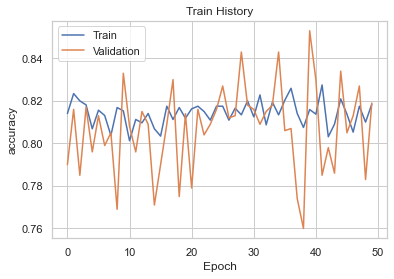

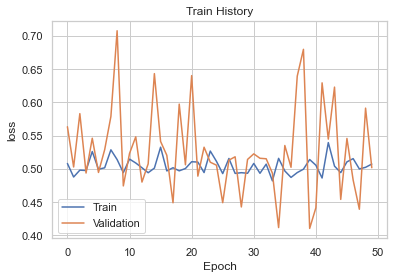

In [154]:
train_history = model.fit_generator(datagen.flow(images_train_features,
                images_train_label, batch_size = 64), epochs = 50,
                validation_data = (images_val_features, images_val_label), 
                steps_per_epoch = len(images_train_features) // 64)
show_train_history(train_history,'accuracy','val_accuracy')
show_train_history(train_history,'loss','val_loss')

25/25 [==============================] - 2s 78ms/step
Accuracy score of the test data is 0.8375


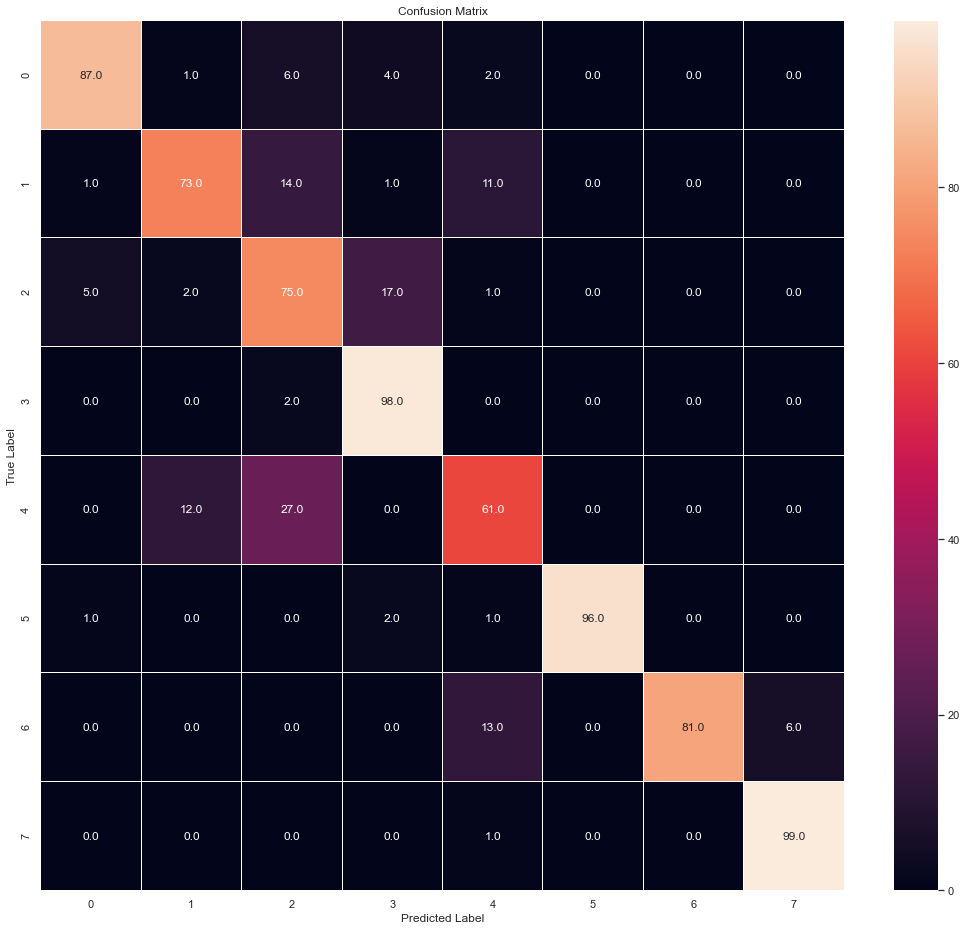

In [155]:
# Predict the values from the validation dataset
Y_pred = model.predict(images_test_features)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(images_test_label,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
print("Accuracy score of the test data is {}".format(accuracy_score(Y_true, np.argmax(Y_pred, axis=1))))

# plot the confusion matrix
f,ax = plt.subplots(figsize=(18, 16))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [156]:
#Y_true_C=Y_true-1
y_test_dummies = pd.get_dummies(Y_true, drop_first=False).values
Y_true[111]

4

In [157]:
y_test_dummies[111][4]

1

In [158]:
Y_pred[43]

array([7.19732561e-05, 1.19771554e-04, 1.12003063e-05, 5.64134961e-10,
       9.99796927e-01, 1.47585126e-07, 1.82955506e-09, 2.36049437e-29],
      dtype=float32)

In [159]:
Y_pred[15]

array([9.2523593e-01, 1.8059462e-03, 7.0425078e-02, 1.7283325e-03,
       2.0118935e-04, 6.0345093e-04, 2.3435657e-12, 3.5918715e-16],
      dtype=float32)

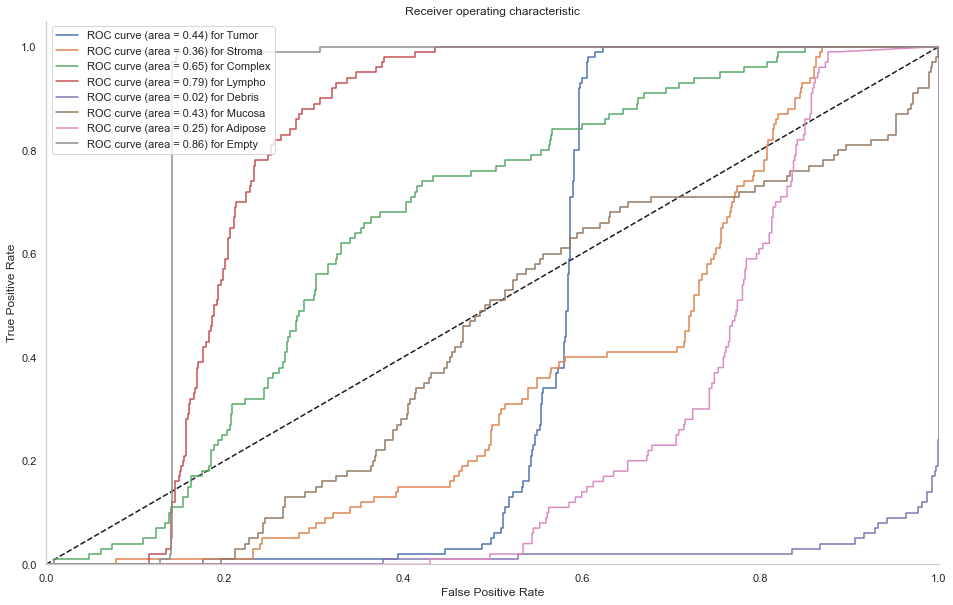

In [160]:
from sklearn.metrics import roc_curve, auc

def plot_multiclass_roc(y_true, y_pred, n_classes, figsize=(17, 6)):
    #y_true_t = y_true-1
    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_true, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i-1], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], class_names[i+1]))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

plot_multiclass_roc(Y_true, Y_pred, n_classes=8, figsize=(16, 10))